# ACTIVIDAD DE CLASIFICACIÓN DE TEXTO

En esta actividad vamos a trabajar en clasificar textos. Se recorrerá todo el proceso desde traer el dataset hasta proceder a dicha clasificación. Durante la actividad se llevarán a cabo muchos procesos como la creación de un vocabulario, el uso de embeddings y la creación de modelos.

Las cuestiones presentes en esta actividad están basadas en un Notebook creado por François Chollet, uno de los creadores de Keras y autor del libro "Deep Learning with Python".

En este Notebook se trabaja con el dataset "Newsgroup20" que contiene aproximadamente 20000 mensajes que pertenecen a 20 categorías diferentes.

El objetivo es entender los conceptos que se trabajan y ser capaz de hacer pequeñas experimentaciones para mejorar el Notebook creado.

# Librerías

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Descarga de Datos

In [49]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

In [50]:
import os
import pathlib

#Estructura de directorios del dataset
data_dir = pathlib.Path(data_path) / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

Number of directories: 20
Directory names: ['soc.religion.christian', 'rec.sport.baseball', 'rec.autos', 'alt.atheism', 'talk.politics.misc', 'comp.sys.ibm.pc.hardware', 'comp.graphics', 'rec.motorcycles', 'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space', 'misc.forsale', 'sci.electronics', 'talk.politics.guns', 'talk.politics.mideast', 'rec.sport.hockey', 'comp.os.ms-windows.misc', 'sci.med', 'talk.religion.misc', 'sci.crypt']


In [51]:
print(data_dir)

/root/.keras/datasets/news20_extracted/20_newsgroup


In [52]:
#Algunos archivos de la categoria "com.graphics"
fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of files in comp.graphics: 1000
Some example filenames: ['38258', '38778', '38884', '38337', '38585']


In [53]:
#Ejemplo de un texto de la categoría "com.graphics"
print(open(data_dir / "comp.graphics" / "37261").read())

Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:37261 alt.graphics:519 comp.graphics.animation:2614
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!zaphod.mps.ohio-state.edu!darwin.sura.net!dtix.dt.navy.mil!oasys!lipman
From: lipman@oasys.dt.navy.mil (Robert Lipman)
Newsgroups: comp.graphics,alt.graphics,comp.graphics.animation
Subject: CALL FOR PRESENTATIONS: Navy SciViz/VR Seminar
Message-ID: <32850@oasys.dt.navy.mil>
Date: 19 Mar 93 20:10:23 GMT
Article-I.D.: oasys.32850
Expires: 30 Apr 93 04:00:00 GMT
Reply-To: lipman@oasys.dt.navy.mil (Robert Lipman)
Followup-To: comp.graphics
Distribution: usa
Organization: Carderock Division, NSWC, Bethesda, MD
Lines: 65


			CALL FOR PRESENTATIONS
	
      NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR

			Tuesday, June 22, 1993

	    Carderock Division, Naval Surface Warfare Center
	      (formerly the David Taylor Research Center)
			  Bethesda, Maryland

SPONSOR: NESS (Navy Engineering Software System) is sponsori

###Pregunta 1

Tienen que ser valores random, no siempre los 15 primeros

In [54]:
import spacy
import random

nlp = spacy.load("en_core_web_sm")

comp_graphics_files = os.listdir(data_dir / "comp.graphics")
random_files = random.sample(comp_graphics_files, 15)

token_counts = []

for fname in random_files:
    file_path = data_dir / "comp.graphics" / fname
    with open(file_path, "r", encoding="latin-1") as f:
        content = f.read()
        lines = content.split("\n")[10:]
        text = "\n".join(lines)
        doc = nlp(text)
        token_counts.append(len(doc))

avg_tokens = sum(token_counts) / len(token_counts)
print(f"Número promedio de tokens en los 15 archivos de 'comp.graphics': {avg_tokens:.2f}")

Número promedio de tokens en los 15 archivos de 'comp.graphics': 180.33


In [55]:
for length in [100, 200, 300, 500, 1000]:
  truncados = sum(1 for t in token_counts if t > length)
  porcentaje = (truncados / len(token_counts)) * 100
  print(f"Con {length} tokens -> {truncados} truncados ({porcentaje:.2f}%)")


Con 100 tokens -> 10 truncados (66.67%)
Con 200 tokens -> 4 truncados (26.67%)
Con 300 tokens -> 2 truncados (13.33%)
Con 500 tokens -> 1 truncados (6.67%)
Con 1000 tokens -> 0 truncados (0.00%)


In [56]:
#Algunos archivos de la categoria "talk.politics.misc"
fnames = os.listdir(data_dir / "talk.politics.misc")
print("Number of files in talk.politics.misc:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of files in talk.politics.misc: 1000
Some example filenames: ['178913', '178805', '178437', '178859', '176903']


In [57]:
#Ejemplo de un texto de la categoría "talk.politics.misc"
print(open(data_dir / "talk.politics.misc" / "178463").read())

Xref: cantaloupe.srv.cs.cmu.edu talk.politics.guns:54219 talk.politics.misc:178463
Newsgroups: talk.politics.guns,talk.politics.misc
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!darwin.sura.net!martha.utcc.utk.edu!FRANKENSTEIN.CE.UTK.EDU!VEAL
From: VEAL@utkvm1.utk.edu (David Veal)
Subject: Re: Proof of the Viability of Gun Control
Message-ID: <VEAL.749.735192116@utkvm1.utk.edu>
Lines: 21
Sender: usenet@martha.utcc.utk.edu (USENET News System)
Organization: University of Tennessee Division of Continuing Education
References: <1qpbqd$ntl@access.digex.net> <C5otvp.ItL@magpie.linknet.com>
Date: Mon, 19 Apr 1993 04:01:56 GMT

[alt.drugs and alt.conspiracy removed from newsgroups line.]

In article <C5otvp.ItL@magpie.linknet.com> neal@magpie.linknet.com (Neal) writes:

>   Once the National Guard has been called into federal service,
>it is under the command of the present. Tha N

In [58]:
list_all_dir = [
    'alt.atheism',
    'comp.graphics',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.misc',
    'talk.religion.misc'
]

In [59]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in list_all_dir:
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.misc', 'talk.religion.misc']
Number of samples: 14997


###Pregunta 2

In [60]:
comp_graphics_files = os.listdir(data_dir / "sci.crypt")[:15]
fname = comp_graphics_files[0]
file_path = data_dir / "sci.crypt" / fname

with open(file_path, "r", encoding="latin-1") as f:
  lineas = f.readlines()

print("Primeras 15 líneas antes del descarte:\n")
print("".join(lineas[:15]))

contenido_sin_encabezado = lineas[10:]

print("\nPrimeras 5 líneas después del descarte:\n")
print("".join(contenido_sin_encabezado[:5]))

Primeras 15 líneas antes del descarte:

Xref: cantaloupe.srv.cs.cmu.edu sci.crypt:15882 alt.privacy.clipper:111
Newsgroups: sci.crypt,alt.privacy.clipper
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!wupost!mont!mizzou1.missouri.edu!C445585
From: C445585@mizzou1.missouri.edu (John Kelsey)
Subject: How to make the Clipper chip and wiretapping less bad
Message-ID: <16BB9E8A1.C445585@mizzou1.missouri.edu>
Sender: news@mont.cs.missouri.edu
Nntp-Posting-Host: mizzou1.missouri.edu
Organization: University of Missouri
References: <1993Apr19.154938.1203@lambda.msfc.nasa.gov> <C5y746.73K@vcd.hp.com> <strnlghtC5yBKA.Dp5@netcom.com>
Date: Fri, 23 Apr 93 16:32:20 CDT
Lines: 15

   I've got an idea that would remove most of the political complaints
I have about the Clipper chip.  Pass a law stating that if, within a


Primeras 5 líneas después del descarte:

Date: Fri, 23 Apr 93 16:32:20 CDT
Lines: 15

   I've got an idea tha

# Mezclando los datos para separarlos en Traning y Test

In [61]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)
keras.utils.set_random_seed(seed)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

###Pregunta 4

In [62]:
# Imprimir un ejemplo de cada conjunto
label_map = {i: name for i, name in enumerate(list_all_dir)}
print("Ejemplo de train_samples:\n", train_samples[0])
print(f"Etiqueta train_labels: {train_labels[0]} -> Categoría: {label_map[train_labels[0]]}")

print("\nEjemplo de val_samples:\n", val_samples[0])
print(f"Etiqueta val_labels: {val_labels[0]} -> Categoría: {label_map[val_labels[0]]}")


Ejemplo de train_samples:
 Lines: 13

In article <C5t05K.DB6@research.canon.oz.au>, enzo@research.canon.oz.au (Enzo Liguori) writes:

<<<most of message deleted>>>

> What about light pollution in observations? (I read somewhere else that
> it might even be visible during the day, leave alone at night).

> Really, really depressed.
> 
>              Enzo

No need to be depressed about this one.  Lights aren't on during the day
so there shouldn't be any daytime light pollution.

Etiqueta train_labels: 10 -> Categoría: sci.space

Ejemplo de val_samples:
 NNTP-Posting-Host: hardy.u.washington.edu

pb6755@csc.albany.edu (BROWN PHILIP H) writes:

>I watched the final inning of Bosio's no-hitter with several people at
>work. After Vizquel made that barehanded grab of the chopper up the
>middle, someone remarked that if he had fielded it with his glove, he
>wouldn't have had time to throw Riles out. Yet, the throw beat Riles
>by about two steps. I wonder how many others who watched the final 

###Pregunta 3

In [63]:
import numpy as np

num_samples = 1000

# Probar diferentes valores de validation_split
for split in [0.1, 0.2, 0.3, 0.4, 0.5]:
    num_validation = int(num_samples * split)  # Cantidad de datos para validación
    num_training = num_samples - num_validation  # Cantidad de datos para entrenamiento

    print(f"validation_split = {split}")
    print(f"Datos de entrenamiento: {num_training}")
    print(f"Datos de validación: {num_validation}\n")

validation_split = 0.1
Datos de entrenamiento: 900
Datos de validación: 100

validation_split = 0.2
Datos de entrenamiento: 800
Datos de validación: 200

validation_split = 0.3
Datos de entrenamiento: 700
Datos de validación: 300

validation_split = 0.4
Datos de entrenamiento: 600
Datos de validación: 400

validation_split = 0.5
Datos de entrenamiento: 500
Datos de validación: 500



In [64]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Simulación de datos
X = np.random.rand(1000, 20)  # 1000 muestras con 20 características
y = np.random.randint(0, 2, 1000)  # Clases binarias (0 o 1)

# Probar con diferentes valores de validation_split
for split in [0.1, 0.2, 0.3]:
    print(f"\nEntrenando con validation_split = {split}")

    # Dividir los datos
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split, random_state=42)

    # Crear un modelo simple
    model = keras.Sequential([
        keras.layers.Dense(16, activation="relu", input_shape=(20,)),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=1)



Entrenando con validation_split = 0.1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4911 - loss: 0.7231 - val_accuracy: 0.4800 - val_loss: 0.7194
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5112 - loss: 0.7002 - val_accuracy: 0.4800 - val_loss: 0.7175
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5258 - loss: 0.6979 - val_accuracy: 0.4900 - val_loss: 0.7163
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5280 - loss: 0.6967 - val_accuracy: 0.4700 - val_loss: 0.7146
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5267 - loss: 0.6954 - val_accuracy: 0.4800 - val_loss: 0.7129

Entrenando con validation_split = 0.2
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4758 - loss: 0.7014 - val_accuracy: 0.5500 - val_loss: 0.6845
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5023 - loss: 0.6970 - val_accuracy: 0.5550 - val_loss: 0.6840
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5066 - loss: 0.6959 - val_accur

# Tokenización de las palabras con TextVectorization

In [65]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

###Pregunta 5

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Máxima longitud: 11872
Media de tokens por muestra: 422.11
Mediana de tokens por muestra: 244.0


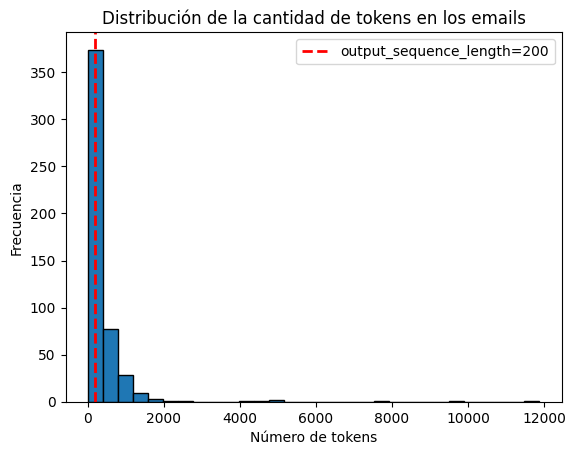

In [66]:
import spacy
import numpy as np
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

aux = train_samples[:500]

# Contar tokens en cada muestra de entrenamiento
token_counts = [len(nlp(text, disable=["parser", "tagger", "ner"])) for text in aux]

# Mostrar estadísticas básicas
print(f"Máxima longitud: {max(token_counts)}")
print(f"Media de tokens por muestra: {np.mean(token_counts):.2f}")
print(f"Mediana de tokens por muestra: {np.median(token_counts)}")

# Graficar la distribución de longitudes
plt.hist(token_counts, bins=30, edgecolor='black')
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=2, label="output_sequence_length=200")
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.title("Distribución de la cantidad de tokens en los emails")
plt.legend()
plt.show()

In [67]:
# Contar cuántos textos son más largos que 200 tokens
num_truncated = sum(1 for count in token_counts if count > 200)
percent_truncated = (num_truncated / len(token_counts)) * 100

print(f"Número de textos truncados: {num_truncated}")
print(f"Porcentaje de textos truncados: {percent_truncated:.2f}%")


Número de textos truncados: 293
Porcentaje de textos truncados: 58.60%


Máxima longitud: 16473
Media de tokens por muestra: 395.23
Mediana de tokens por muestra: 242.0


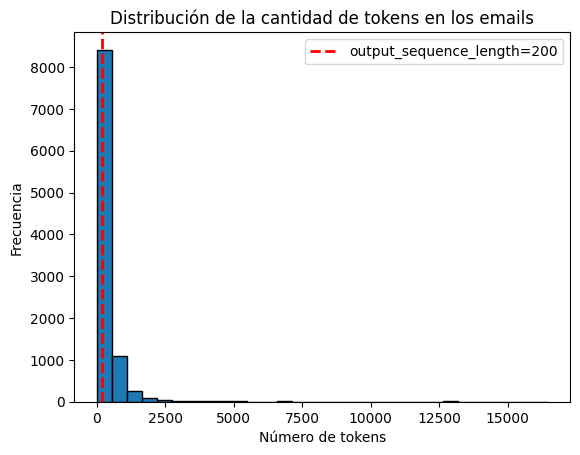

In [68]:
import spacy
import numpy as np
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

# Usar nlp.pipe() y desactivar funciones innecesarias
token_counts = [len(doc) for doc in nlp.pipe(train_samples[:10000], disable=["parser", "tagger", "ner"])]

# Mostrar estadísticas
print(f"Máxima longitud: {max(token_counts)}")
print(f"Media de tokens por muestra: {np.mean(token_counts):.2f}")
print(f"Mediana de tokens por muestra: {np.median(token_counts)}")

# Graficar
plt.hist(token_counts, bins=30, edgecolor='black')
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=2, label="output_sequence_length=200")
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.title("Distribución de la cantidad de tokens en los emails")
plt.legend()
plt.show()


In [69]:
for length in [100, 200, 300, 500, 1000]:
  truncados = sum(1 for t in token_counts if t > length)
  porcentaje = (truncados / len(token_counts)) * 100
  print(f"Con {length} tokens -> {truncados} truncados ({porcentaje:.2f}%)")


Con 100 tokens -> 8406 truncados (84.06%)
Con 200 tokens -> 5894 truncados (58.94%)
Con 300 tokens -> 3961 truncados (39.61%)
Con 500 tokens -> 1902 truncados (19.02%)
Con 1000 tokens -> 584 truncados (5.84%)


In [70]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

In [71]:
len(vectorizer.get_vocabulary())

20000

# Viendo la salida de Vectorizer

In [72]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 3709, 2056,   19,    2, 9656])

In [73]:
output

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[   2, 3709, 2056,   19,    2, 9656,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [74]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [75]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3709, 2056, 19, 2, 9656]

# Tokenización de los datos de entrenamiento y validación

In [76]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

# Creación y entrenamiento del modelo. Red Neuronal Clásica

In [77]:
modeloClasico = keras.models.Sequential()
modeloClasico.add(keras.layers.Embedding(20000, 10))
modeloClasico.add(keras.layers.Flatten())
modeloClasico.add(keras.layers.Dense(512, activation='relu'))
modeloClasico.add(keras.layers.Dropout(0.3))
modeloClasico.add(keras.layers.Dense(20, activation='softmax'))

In [78]:
modeloClasico.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modeloClasico.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
modeloClasico.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))
print(modeloClasico.summary())

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - acc: 0.0925 - loss: 2.7846 - val_acc: 0.1917 - val_loss: 2.4306
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.2508 - loss: 2.2679 - val_acc: 0.3184 - val_loss: 1.9776
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.4632 - loss: 1.6589 - val_acc: 0.4565 - val_loss: 1.6475
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - acc: 0.6555 - loss: 1.1215 - val_acc: 0.5649 - val_loss: 1.2942
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.7795 - loss: 0.7529 - val_acc: 0.6295 - val_loss: 1.0704
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - acc: 0.8543 - loss: 0.5108 - val_acc: 0.6619 - val_loss: 0.9842
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.8978 - loss: 0.3650 - val_acc: 0.6809 - val_loss: 0.9598
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - acc: 0.9190 - loss: 0.2764 - val_acc: 0.6906 - val_loss: 0.9560
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - acc: 0.9338

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 200, 10)             │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │       1,024,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,469,546 (9.42 MB)

 Trainable params: 1,234,772 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,234,774 (4.71 MB)

None


# Evaluación

In [79]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = modeloClasico(x)
end_to_end_model = keras.Model(string_input, preds)

In [80]:
probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["this message is about computer graphics and 3D modeling"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

comp.graphics


In [81]:
probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["politics and federal courts law that people understand with politician and elects congressman"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

rec.sport.hockey


In [82]:
probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["we are talking about religion"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

comp.sys.mac.hardware


###Pregunta 8

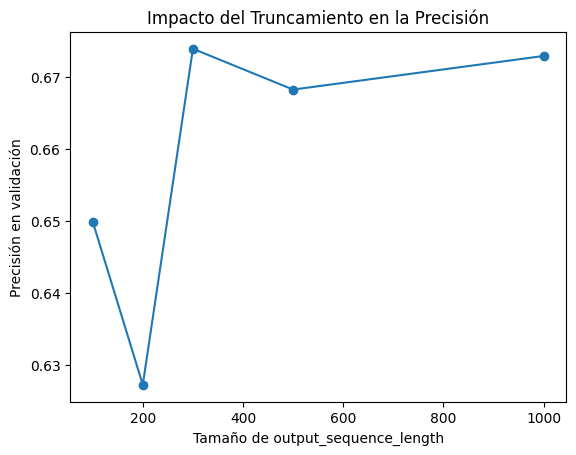

In [83]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sequence_lengths = [100, 200, 300, 500, 1000]  # Distintas longitudes de truncamiento
val_accuracies = []

for seq_length in sequence_lengths:
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=20000, output_mode="int", output_sequence_length=seq_length
    )


    # Crear un modelo simple para evaluar
    modelo = tf.keras.Sequential([
        tf.keras.layers.Embedding(20000, 128),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(len(class_names), activation="softmax")
    ])

    modelo.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Entrenar el modelo
    history = modelo.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val), verbose=0)

    # Guardar la precisión en validación
    val_accuracies.append(history.history["val_accuracy"][-1])

# Graficar los resultados
plt.plot(sequence_lengths, val_accuracies, marker="o")
plt.xlabel("Tamaño de output_sequence_length")
plt.ylabel("Precisión en validación")
plt.title("Impacto del Truncamiento en la Precisión")
plt.show()


In [84]:
import spacy

nlp = spacy.load("en_core_web_sm")

token_counts = [len(nlp(text)) for text in train_samples]

for seq_length in sequence_lengths:
    truncados = sum(1 for count in token_counts if count > seq_length)
    porcentaje = truncados / len(token_counts) * 100
    print(f"Tamaño {seq_length}: {truncados} textos truncados ({porcentaje:.2f}%)")


Tamaño 100: 10115 textos truncados (84.31%)
Tamaño 200: 7084 textos truncados (59.04%)
Tamaño 300: 4749 textos truncados (39.58%)
Tamaño 500: 2264 textos truncados (18.87%)
Tamaño 1000: 691 textos truncados (5.76%)


In [85]:
def show_truncated_examples(seq_length):
    for text in train_samples:
        tokens = nlp(text)
        if len(tokens) > seq_length:
            print("Texto original:")
            print(text[:500])
            print("\nTexto truncado:")
            print(" ".join([t.text for t in tokens[:seq_length]]))
            print("="*80)
            break

show_truncated_examples(200)

Texto original:
X-Newsreader: TIN [version 1.1.8 PL6]
Lines: 19

arlen.r.martin (arm1@cbnewsm.cb.att.com) wrote:
: Consumer Reports once wrote about the S-10 Blazer that it "shook and rattled
: like a tired taxi cab".  There is one noise that is expecially irritating -
: the back window squeaks.  I believe its because the whole tailgate assembly
: and window are not solid.  Anyway, has anyone had the same problem, and have
: you found any fixes?
:

I can relate to this. I've tried everything on my 86, greasing 

Texto truncado:
X - Newsreader : TIN [ version 1.1.8 PL6 ] 
 Lines : 19 

 arlen.r.martin ( arm1@cbnewsm.cb.att.com ) wrote : 
 : Consumer Reports once wrote about the S-10 Blazer that it " shook and rattled 
 : like a tired taxi cab " .   There is one noise that is expecially irritating - 
 : the back window squeaks .   I believe its because the whole tailgate assembly 
 : and window are not solid .   Anyway , has anyone had the same problem , and have 
 : you found any fixes 

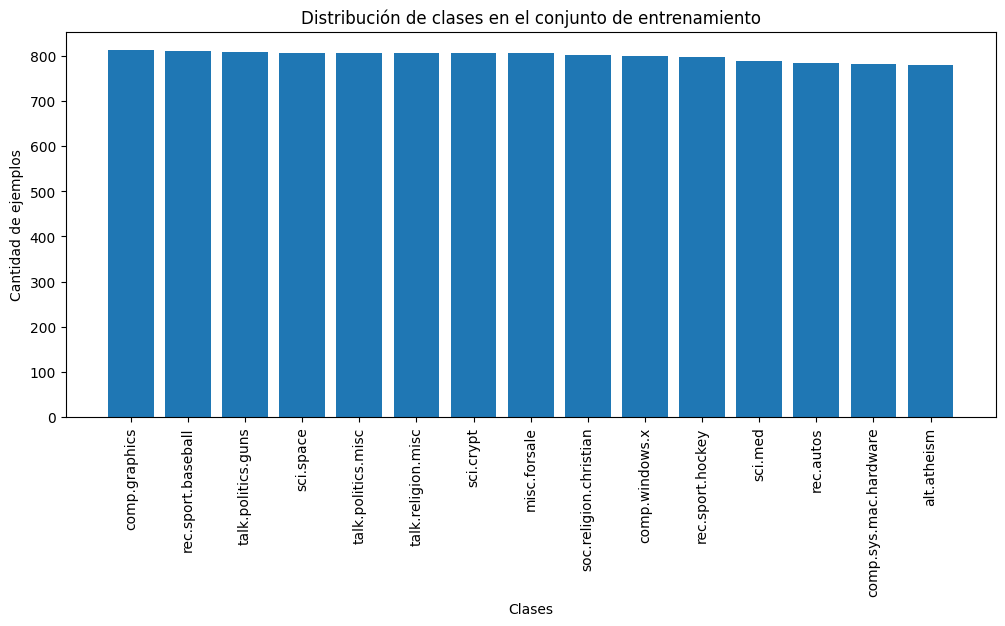

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(y_train)

sorted_classes = sorted(class_counts.keys(), key=lambda x: class_counts[x], reverse=True)
sorted_counts = [class_counts[c] for c in sorted_classes]

plt.figure(figsize=(12,5))
plt.bar(range(len(sorted_classes)), sorted_counts, tick_label=[class_names[c] for c in sorted_classes])
plt.xticks(rotation=90)
plt.xlabel("Clases")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.show()


In [87]:
sorted_counts

[812, 811, 809, 807, 807, 807, 806, 806, 801, 800, 797, 789, 784, 782, 780]

####Analizar los valores de cada clase (desbalanceo)

In [88]:
from sklearn.metrics import classification_report

y_pred = modeloClasico.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes, target_names=class_names))


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                        precision    recall  f1-score   support

           alt.atheism       0.60      0.47      0.53       220
         comp.graphics       0.72      0.55      0.62       188
 comp.sys.mac.hardware       0.70      0.79      0.74       218
        comp.windows.x       0.70      0.80      0.75       200
          misc.forsale       0.82      0.75      0.79       194
             rec.autos       0.79      0.75      0.77       216
    rec.sport.baseball       0.80      0.76      0.78       189
      rec.sport.hockey       0.84      0.87      0.86       203
             sci.crypt       0.92      0.73      0.81       194
               sci.med       0.61      0.72      0.66       211
             sci.space       0.75      0.81      0.78       193
soc.religion.christian       0.74      0.74      0.74       196
    talk.politics.guns       0.55      0.57      0.56       191
    talk.politics.misc       0.49      0.58      0.53       193


####Textos ambiguos

In [89]:
test_texts = [
    "Este coche es una bestia",
    "Los gráficos de este partido son impresionantes",
    "Las vacunas pueden cambiar el mundo",
    "Gané la lotería, pero solo fueron 5 dólares...",
    "Este código está tan limpio que podría comer sobre él",
]

probabilities = end_to_end_model(keras.ops.convert_to_tensor([[text] for text in test_texts]))

for text, prob in zip(test_texts, probabilities):
    print(f"Texto: {text}")
    print(f"Predicción: {class_names[np.argmax(prob)]}")
    print("-" * 50)


Texto: Este coche es una bestia
Predicción: comp.sys.mac.hardware
--------------------------------------------------
Texto: Los gráficos de este partido son impresionantes
Predicción: comp.sys.mac.hardware
--------------------------------------------------
Texto: Las vacunas pueden cambiar el mundo
Predicción: comp.sys.mac.hardware
--------------------------------------------------
Texto: Gané la lotería, pero solo fueron 5 dólares...
Predicción: misc.forsale
--------------------------------------------------
Texto: Este código está tan limpio que podría comer sobre él
Predicción: comp.graphics
--------------------------------------------------


In [90]:
sarc_texts = [
    "¡Oh, claro! Seguro que la tierra es plana.",
    "Este nuevo sistema operativo nunca falla... excepto cuando lo usas.",
    "Nada mejor que un lunes por la mañana",
]

probabilities = end_to_end_model(keras.ops.convert_to_tensor([[text] for text in sarc_texts]))

for text, prob in zip(sarc_texts, probabilities):
    print(f"Texto: {text}")
    print(f"Predicción: {class_names[np.argmax(prob)]}")
    print("-" * 50)


Texto: ¡Oh, claro! Seguro que la tierra es plana.
Predicción: comp.sys.mac.hardware
--------------------------------------------------
Texto: Este nuevo sistema operativo nunca falla... excepto cuando lo usas.
Predicción: comp.graphics
--------------------------------------------------
Texto: Nada mejor que un lunes por la mañana
Predicción: misc.forsale
--------------------------------------------------


####Distintos tamaños

In [91]:
import numpy as np

# Definir los porcentajes que queremos probar
data_sizes = [0.1, 0.3, 0.5, 1.0]  # 10%, 30%, 50%, 100%

# Guardar los resultados de precisión en validación
results = {}

for size in data_sizes:
    print(f"\n🔹 Entrenando con {int(size * 100)}% de los datos...\n")

    # Seleccionar una fracción del dataset
    num_samples = int(len(x_train) * size)
    x_train_subset, y_train_subset = x_train[:num_samples], y_train[:num_samples]

    # Crear un nuevo modelo (para que no arrastre pesos previos)
    modelo = keras.models.clone_model(modeloClasico)
    modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar con el subconjunto de datos
    history = modelo.fit(
        x_train_subset, y_train_subset,
        batch_size=128,
        epochs=10,  # Puedes ajustar el número de épocas
        validation_data=(x_val, y_val),
        verbose=1
    )

    # Guardar la precisión final en validación
    val_acc = history.history["val_accuracy"][-1]
    results[f"{int(size * 100)}%"] = val_acc



🔹 Entrenando con 10% de los datos...

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.0701 - loss: 2.9594 - val_accuracy: 0.0710 - val_loss: 2.8395
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.3965 - loss: 2.7314 - val_accuracy: 0.1077 - val_loss: 2.7524
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4833 - loss: 2.5891 - val_accuracy: 0.1067 - val_loss: 2.7086
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5221 - loss: 2.4016 - val_accuracy: 0.1147 - val_loss: 2.6580
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6074 - loss: 2.0907 - val_accuracy: 0.1307 - val_loss: 2.6241
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7092 - loss: 1.6573 - val_accuracy: 0.1380 - val_loss: 2.6160
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7889 - loss: 1.1932 - val_accuracy: 0.1417 - val_loss: 2.6544
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8724 

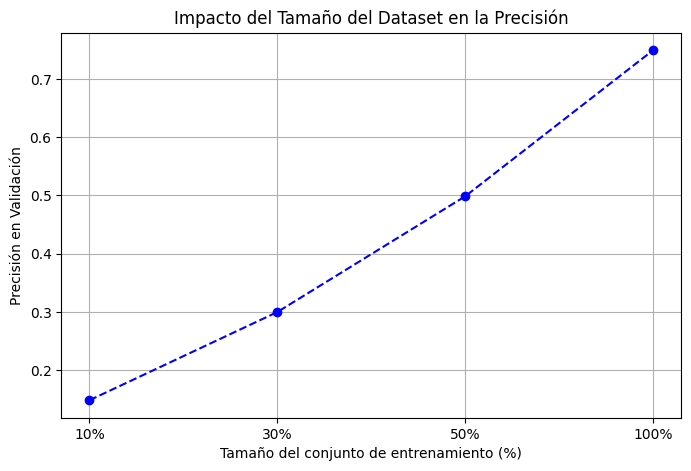

In [92]:
import matplotlib.pyplot as plt

# Convertir los datos a listas para graficar
sizes = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8,5))
plt.plot(sizes, accuracies, marker="o", linestyle="--", color="b")
plt.xlabel("Tamaño del conjunto de entrenamiento (%)")
plt.ylabel("Precisión en Validación")
plt.title("Impacto del Tamaño del Dataset en la Precisión")
plt.grid(True)
plt.show()
